In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import requests
import os
import sys

from sklearn.feature_selection import SelectFromModel
from skimage import data as imgData, feature, exposure
from skimage.io import imread_collection, imshow, imread
from sklearn.feature_extraction import DictVectorizer, image
from PIL import Image

In [3]:
sns.set(color_codes=True)
data = pd.read_json('train.json', convert_dates=['created'])

# 1. 1

Text(0, 0.5, 'Number')

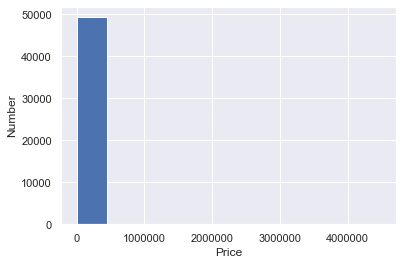

In [4]:
plt.hist(data['price'])
plt.xlabel("Price")
plt.ylabel("Number")

Text(0, 0.5, 'Number')

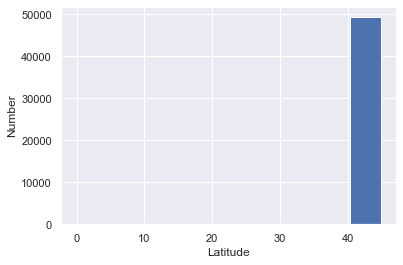

In [5]:
plt.hist(data['latitude'])
plt.xlabel("Latitude")
plt.ylabel("Number")

Text(0, 0.5, 'Number')

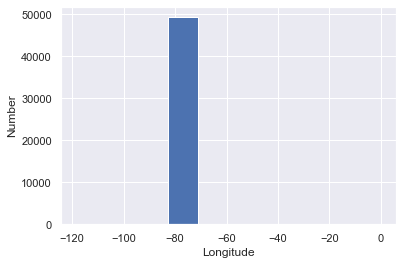

In [6]:
plt.hist(data['longitude'])
plt.xlabel("Longitude")
plt.ylabel("Number")

# 1.2 

In [7]:
#add hour column
def hour(d):
    return d.hour
data['hour'] = data['created'].apply(hour)

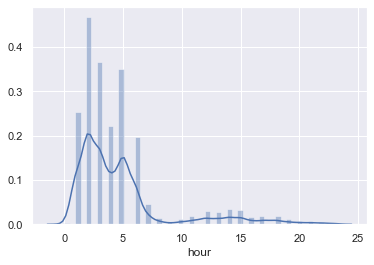

In [8]:
sns.distplot(data['hour']);

# 1.3

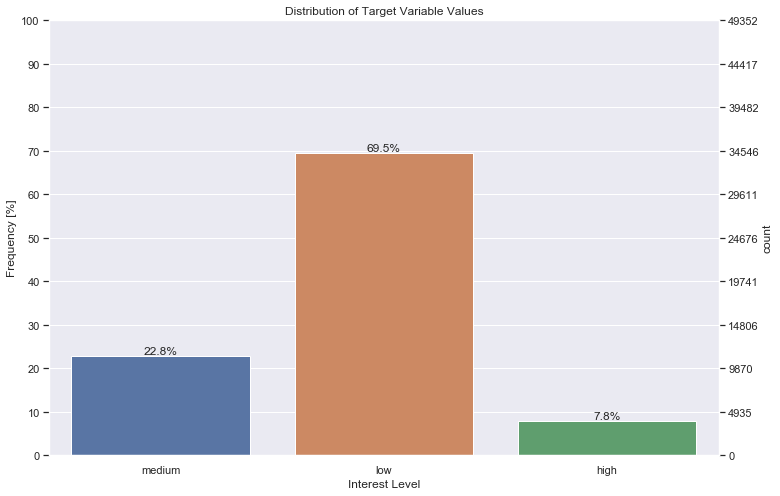

In [9]:
#reference: https://stackoverflow.com/questions/33179122/seaborn-countplot-with-frequencies
ncount = len(data)

plt.figure(figsize=(12,8))
ax = sns.countplot(x="interest_level", data=data)
plt.title('Distribution of Target Variable Values')
plt.xlabel('Interest Level')

# Make twin axis
ax2=ax.twinx()

# Switch so count axis is on right, frequency on left
ax2.yaxis.tick_left()
ax.yaxis.tick_right()

# Also switch the labels over
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

ax2.set_ylabel('Frequency [%]')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text

# Use a LinearLocator to ensure the correct number of ticks
ax.yaxis.set_major_locator(ticker.LinearLocator(11))

# Fix the frequency range to 0-100
ax2.set_ylim(0,100)
ax.set_ylim(0,ncount)

# And use a MultipleLocator to ensure a tick spacing of 10
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

# Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
ax2.grid(None)

# plt.savefig('snscounter.pdf')

# 2.1
There are only two variables have missing values, features and photos. 3218 rows missing features variable, 3615 rows missing photos variable.

In [10]:
data_no_features = data[data['features'].str.len() == 0]
data_no_photos = data[data['photos'].str.len() == 0]

In [11]:
data_no_features.shape

(3218, 16)

In [12]:
data_no_photos.shape

(3615, 16)

# 2.2
We should detect outlier for price, longitude, latitude

### Price

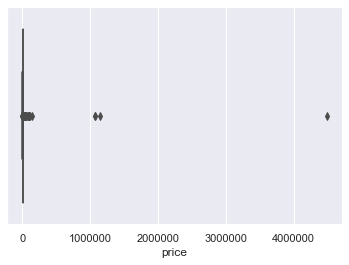

In [13]:
sns.boxplot(x=data["price"])

From the above graph, the majority portion of the data range is 0 ~ 200000.

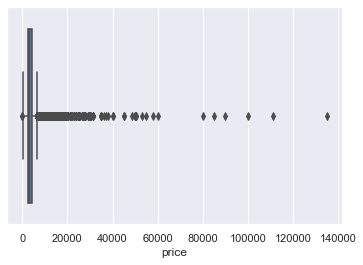

In [14]:
data_price_no_outliers = data[data['price'] < 250000]
sns.boxplot(x=data_price_no_outliers["price"])

From the above graph, there are still some outliers, the majority portion of the data range is under 6000

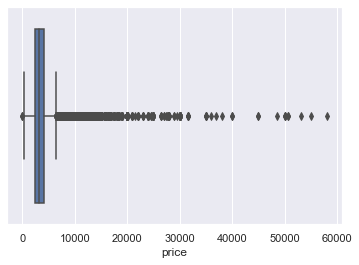

In [15]:
data_price_no_outliers = data[data['price'] < 60000]
sns.boxplot(x=data_price_no_outliers["price"])

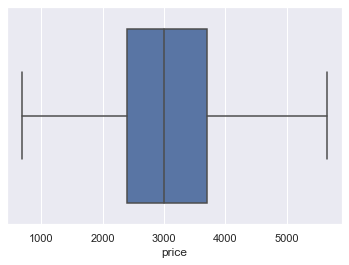

In [16]:
data_price_no_outliers = data[data['price'] <= 5651]
data_price_no_outliers = data_price_no_outliers[data_price_no_outliers['price'] >= 402]
sns.boxplot(x=data_price_no_outliers["price"])

Text(0, 0.5, 'Number')

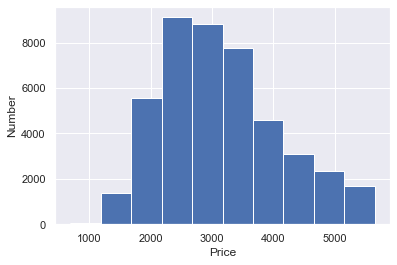

In [17]:
plt.hist(data_price_no_outliers['price'])
plt.xlabel("Price")
plt.ylabel("Number")

In [18]:
data.shape[0] - data_price_no_outliers.shape[0]

4939

###  Compared the graph at section 1.1， this graph shows better distribution, so there are 4939 rows with price outliers

## Latitude

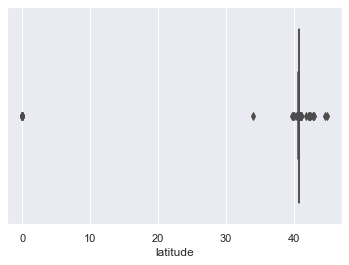

In [19]:
sns.boxplot(x=data["latitude"])

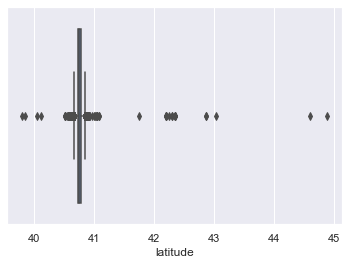

In [20]:
data_latitude_no_outliers = data[data['latitude'] > 35]
sns.boxplot(x=data_latitude_no_outliers["latitude"])

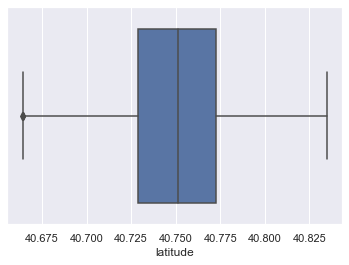

In [21]:
data_latitude_no_outliers = data[data['latitude'] >= 40.664]
data_latitude_no_outliers = data_latitude_no_outliers[data_latitude_no_outliers['latitude'] <= 40.835]
sns.boxplot(x=data_latitude_no_outliers["latitude"])

Text(0, 0.5, 'Number')

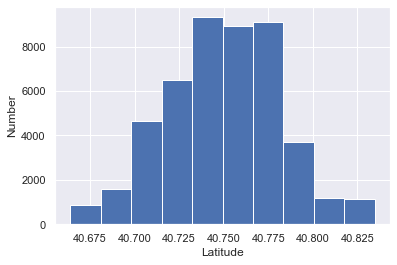

In [22]:
plt.hist(data_latitude_no_outliers['latitude'])
plt.xlabel("Latitude")
plt.ylabel("Number")

In [23]:
data.shape[0] - data_latitude_no_outliers.shape[0]

2371

### Compared the graph at section 1.1， this graph shows better distribution, so there are 2371 rows with latitude outliers

# Longitude

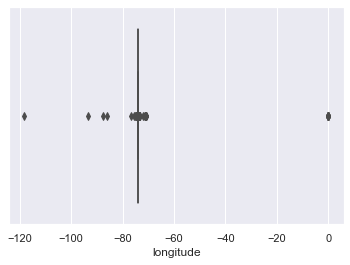

In [24]:
sns.boxplot(x=data["longitude"])

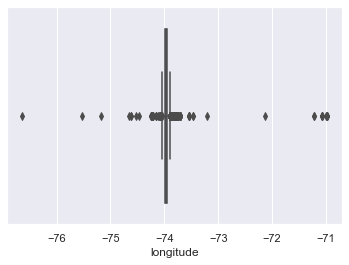

In [25]:
data_longitude_no_outliers = data[data['longitude'] >= -80]
data_longitude_no_outliers = data_longitude_no_outliers[data_longitude_no_outliers['longitude'] <= -60]
sns.boxplot(x=data_longitude_no_outliers["longitude"])

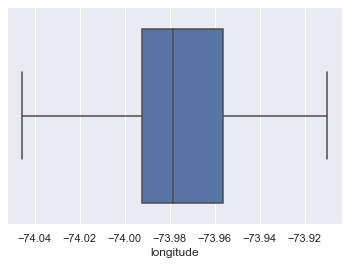

In [26]:
data_longitude_no_outliers = data[data['longitude'] >= -74.048]
data_longitude_no_outliers = data_longitude_no_outliers[data_longitude_no_outliers['longitude'] <= -73.91]
sns.boxplot(x=data_longitude_no_outliers["longitude"])

Text(0, 0.5, 'Number')

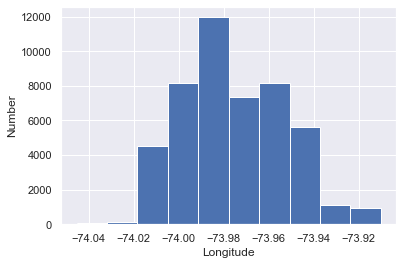

In [27]:
plt.hist(data_longitude_no_outliers['longitude'])
plt.xlabel("Longitude")
plt.ylabel("Number")

In [28]:
data.shape[0] - data_longitude_no_outliers.shape[0]

1355

### Compared the graph at section 1.1， this graph shows better distributions, there are 1355 rows with latitude outliers

### Clean Data
remove outliers jointly

In [29]:
condition = (data['price'] >= 402) & (data['price'] <= 5652) & (data['latitude'] >= 40.664 ) & (data['latitude'] <= 40.835) & (data['longitude'] >= -74.048) & (data['longitude'] <= -73.91)

In [1]:
data = data.loc[condition].reset_index()
data

NameError: name 'data' is not defined

# 2.3


We should not drop missing value, we should replace missing values by predicted values from the model instead.

# 3 feature extraction

## Basic features

- Number of photos in each posting
- Number of features user included in each posting
- length of the description text
- price per bedroom
- price per bathroom
- price per (bedroom+bathroom)
- interest rate converted to numerical value (1, 2 ,3)
- distance to New York city center in longtitude and latitude unit

In [31]:
data['num_of_photos'] = data['photos'].map(len)
data['num_of_features'] = data['features'].map(len)
data['len_of_description'] = data['description'].map(len)

# price per room
data['price_per_bedroom'] = data['price'] / data['bedrooms']
data['price_per_bathroom'] = data['price'] / data['bathrooms']
data['price_per_bed_bath_room'] = data['price'] / (data['bedrooms'] + data['bathrooms'])

# convert interest_level into numerical values
interest_map = {'low':1, 'medium':2, 'high':3}
data['interest_level'] = data['interest_level'].apply(lambda x: interest_map[x])

# distance to city center
city_center = [40.7128, -74.0060]
data['dist_to_city_center'] = list(map(lambda lng, lat: np.sqrt((lat - city_center[0])**2 + (lng - city_center[1])**2), data['longitude'], data['latitude']))


## Image feature
We'll extract 3 features from each image. Also store all the colors/pixels of each image in a 3D array
- descriptor for Histogram of oriented gradients of the image
    > The histogram of oriented gradients (HOG) is a feature descriptor used in computer vision and image processing for the purpose of object detection. The technique counts occurrences of gradient orientation in localized portions of an image. This method is similar to that of edge orientation histograms, scale-invariant feature transform descriptors, and shape contexts, but differs in that it is computed on a dense grid of uniformly spaced cells and uses overlapping local contrast normalization for improved accuracy.
- hessian_matrix_det of the image
    > In mathematics, the Hessian matrix or Hessian is a square matrix of second-order partial derivatives of a scalar-valued function, or scalar field. It describes the local curvature of a function of many variables. The Hessian matrix was developed in the 19th century by the German mathematician Ludwig Otto Hesse and later named after him. Hesse originally used the term "functional determinants".
- The size of the image
    - the height and width

In [32]:
startdir = os.getcwd() + '\\images_sample'
photos_to_extract = []

for root, subdirs, files in os.walk(startdir):    
    for file in files:
        if os.path.splitext(file)[1].lower() in ('.jpg', '.jpeg'):
            path = os.path.join(root, file)
            photos_to_extract.append(path)
#             print(path)
#     print(photos_to_extract)

extracted = imread_collection(photos_to_extract)
# print(extracted[0])
# imshow(extracted[0])
imgfeaturesList = []
for photo in extracted: 
    h_mat_det = feature.hessian_matrix_det(photo)
    fd, hog_image = feature.hog(photo, orientations=8, pixels_per_cell=(16, 16),
                        cells_per_block=(1, 1), visualize=True, multichannel=True)
    img_height = len(photo[0])
    img_width = len(photo[0][0])
    imgfeaturesList.append([photo, h_mat_det, fd, img_height, img_width])
#     print(fd)
# print(imgfeaturesList)
imgfeatures = pd.DataFrame(imgfeaturesList, columns = ['pixels', 'hog_desc', 'h_mat_det', 'img_height', 'img_width']);
imgfeatures

## Text feature extraction

### Some positive adjectives appeared in the description may have possitive effect to the posting's interest rate. Count the times that the possitive adjectives appeared. (the keywords array can be expanded in real-world practice)
- count of each possitive adjs
- count of all possitive adjs

In [ ]:
keywords = ['quiet', 'new', 'close', 'spacious', 'convinient', 'safe', 'care']
for kw in keywords:
    col_name = '_'.join(['kw'] + kw.split() + ['count'])
    data[col_name] = [(s.lower().count(kw)) if s is not np.nan else 0 for s in data['description']]

def countPos(desc):
    i = 0
    desc = desc.lower()
    for kw in keywords:
        if kw in desc:
            i = i + desc.count(kw)
    return i
    
    
data['pos_count'] = data['description'].apply(countPos)

data

## Graph showing the correlation between the extracted features

In [ ]:
data = data.drop(['building_id','created','description' ,'display_address', 'features', 'manager_id', 'photos'], axis=1)
cor = data.corr()
plt.figure(figsize=(15,10))
sns.heatmap(cor, annot=True, vmax=.8, square=True)
data

In [ ]:
data.to_csv('preprocessed.csv', index=False)